In [ ]:
"""
error log
ValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)
output of layer is the first and the target is 64*64*3, need to match output
"""

In [1]:
import os
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from os import listdir

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4480380170488876376
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17438008388745715296
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [3]:
import sys
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/FA2018/tutorials/ferienakademie2018-accelerating-physics-with-deep-learning/')
from functions import *

In [4]:
#forces CPU usage
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
os.getcwd()

'C:\\Users\\pkicsiny\\Desktop\\FA2018\\tutorials\\ferienakademie2018-accelerating-physics-with-deep-learning'

In [6]:
dataDir = os.getcwd() + '/data/trainSmallFA'
files = listdir(dataDir)
files[0:5]

['sm_goe503_1050_57.npz',
 'sm_goe503_1079_209.npz',
 'sm_goe503_1093_355.npz',
 'sm_goe503_1110_304.npz',
 'sm_goe503_1152_78.npz']

In [7]:
totalLength = len(files)

In [8]:
#array of inputs and outputs (predictions of the network)
inputs = np.empty((totalLength,3,64,64))
targets = np.empty_like(inputs)

In [9]:
np.shape(inputs) == np.shape(targets)

True

### Data prerpocessing

In [10]:
c = 1
for i, file in enumerate(files):
    npfile = np.load(dataDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    inputs[i]  = d[0:3]   # inx, iny, mask 
    targets[i] = d[3:6]   # p, velx, vely
    if c:
        print('Shape of input-target array:',np.shape(targets))
        print('Shape of an element of input + output:',np.shape(d))
        # splits input file content of 6 channels to 3-3
        c = 0

Shape of input-target array: (751, 3, 64, 64)
Shape of an element of input + output: (6, 64, 64)


In [11]:
print('Input maxes:',inputs[:,0,:,:].max(), inputs[:,1,:,:].max(), inputs[:,2,:,:].max())
print('Input mins:',inputs[:,0,:,:].min(), inputs[:,1,:,:].min(), inputs[:,2,:,:].min())
print('Target maxes:',targets[:,0,:,:].max(), targets[:,1,:,:].max(), targets[:,2,:,:].max())
print('Target mins:',targets[:,0,:,:].min(), targets[:,1,:,:].min(), targets[:,2,:,:].min())

Input maxes: 98.70918772289284 36.22861719358889 1.0
Input mins: 0.0 0.0 0.0
Target maxes: 4321.8 171.772 140.251
Target mins: -13757.3 -71.886 -58.4272


In [12]:
normalized_inputs, normalized_targets, vxmax, vymax = normalize_data(inputs,targets,norm = 1)

In [13]:
print('Normalized input maxes:',normalized_inputs[:,0,:,:].max(), normalized_inputs[:,1,:,:].max(), normalized_inputs[:,2,:,:].max())
print('Normalized input mins:',normalized_inputs[:,0,:,:].min(), normalized_inputs[:,1,:,:].min(), normalized_inputs[:,2,:,:].min())
print('Normalized target maxes:',normalized_targets[:,0,:,:].max(), normalized_targets[:,1,:,:].max(), normalized_targets[:,2,:,:].max())
print('Normalized target mins:',normalized_targets[:,0,:,:].min(), normalized_targets[:,1,:,:].min(), normalized_targets[:,2,:,:].min())

Normalized input maxes: 98.70918772289284 36.22861719358889 1.0
Normalized input mins: 0.0 0.0 0.0
Normalized target maxes: 0.5181714179504846 1.739651600742902 1.7284380207634795
Normalized target mins: -1.957152811908768 -0.729521000704373 -0.7706419276952202


### Split datasets

In [14]:
#read test dataset
testDir = os.getcwd() + '/data/testDataSetFinal'
testFiles = listdir(testDir)

In [15]:
test_inputs = []
test_targets = []
for i, file in enumerate(testFiles):
    npfile = np.load(testDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    test_inputs.append(d[0:3])   # inx, iny, mask 
    test_targets.append(d[3:6])   # p, velx, vely
test_inputs = np.asarray(test_inputs)
test_targets = np.asarray(test_targets)


In [16]:
n_test_inputs, n_test_targets, n_vxmax, n_vymax = normalize_data(test_inputs,test_targets,norm = 1)

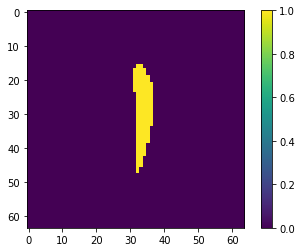

In [17]:
plt.imshow(test_inputs[0,2,:,:])
plt.colorbar()

In [18]:
train_val_inputs = normalized_inputs
train_val_targets = normalized_targets

In [19]:
#train_val_inputs,train_val_targets,test_inputs,test_targets = randsplit(normalized_inputs,normalized_targets,frac=.9)

In [20]:
#training data
train_val_inputs  = train_val_inputs.transpose(0,2,3,1)
train_val_targets = train_val_targets.transpose(0,2,3,1)

#test dataset
n_test_inputs  = n_test_inputs.transpose(0,2,3,1)
n_test_targets = n_test_targets.transpose(0,2,3,1)

print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(n_test_inputs),np.shape(n_test_targets))

Training data shape: (751, 64, 64, 3) (751, 64, 64, 3)
Test data shape: (10, 64, 64, 3) (10, 64, 64, 3)


In [27]:
#flattening if last layer is fcl
train_val_targets = np.reshape(train_val_targets,(len(train_val_targets),-1))
n_test_targets = np.reshape(n_test_targets,(len(n_test_targets),-1))

In [28]:
print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(n_test_inputs),np.shape(n_test_targets))

Training data shape: (751, 64, 64, 3) (751, 12288)
Test data shape: (10, 64, 64, 3) (10, 12288)


### Network architecture

In [29]:
#convolution filters
f1 = 8
f2 = 3
#kernel size
k1 = 4
k2 = 2
#stride
s1 = 4
s2 = 2
#padding
p1 = 0
p2 = 0

Toy network

In [24]:
model=keras.Sequential()

conv1 = keras.layers.Conv2D(input_shape = (64,64,3),
                              filters = f1,
                              kernel_size=(k1,k1),
                              strides=(s1, s1),
                              padding='valid',
                              data_format = "channels_last",
                             activation = 'tanh')
conv2 = keras.layers.Conv2D(input_shape = (16,16,3),
                              filters = f2,
                              kernel_size=(k2,k2),
                              strides=(s2, s2),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
conv3 = keras.layers.Conv2D(input_shape = (8,8,3),
                              filters = 3,
                              kernel_size=(8,8),
                              strides=(1, 1),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
upsample1 = keras.layers.UpSampling2D(size=(4, 4), data_format="channels_last",input_shape = (8,8,3))
dense1 = keras.layers.Dense(64*64*3,activation='tanh')
#architeccture
model.add(conv1)
model.add(conv2)
model.add(conv3)
model.add(upsample1)
model.add(keras.layers.Flatten())
model.add(dense1)

U-net

In [25]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,3))
ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
Lr1 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
#64
ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
Lr2 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
#32
ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
Lr3 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
#16
ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
Lr4 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
#8
ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
Lr5 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
#4

UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
#8
merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
Lr6 = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
#8
UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
#16
merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
Lr7  = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
#16
UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

#32
Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
Lr8  = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
#64
Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

Conv5   = keras.layers.Conv2D(filters=3,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)

model2 = keras.models.Model(inputs=init, outputs=Conv5)

### Training

In [64]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss='mean_squared_error') 
model.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=10,
          validation_split = 0.1,
          shuffle = True)

Train on 675 samples, validate on 76 samples
Epoch 1/10
675/675 [==============================] - 4s 6ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 2/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 3/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 4/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 5/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 9/10
675/675 [==============================] - 3s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
675/675 [==============================] - 

### Plot loss and network info

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 8)         392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 3)           99        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 3)           579       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 12288)             37761024  
Total params: 37,762,094
Trainable params: 37,762,094
Non-trainable params: 0
________________________________________________________________

In [66]:
hist = model.history

In [67]:
hist.history.keys()

dict_keys(['val_loss', 'loss'])

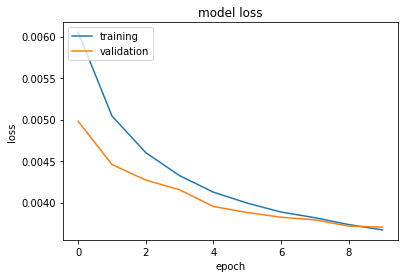

In [68]:
plot_trainingcurves(hist)

### Predicting

In [69]:
#test
predictions = model.predict(n_test_inputs, batch_size=1)
truth     = n_test_targets

predictions = np.reshape(predictions, (len(n_test_inputs),64,64,3))
truth       = np.reshape(truth, (len(n_test_targets),64,64,3))

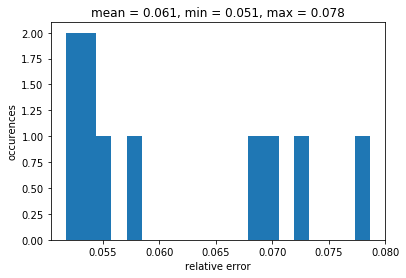

In [70]:
error_distribution(truth,predictions)

In [71]:
args = arg_getter(truth,predictions)

7


### Plot results

3


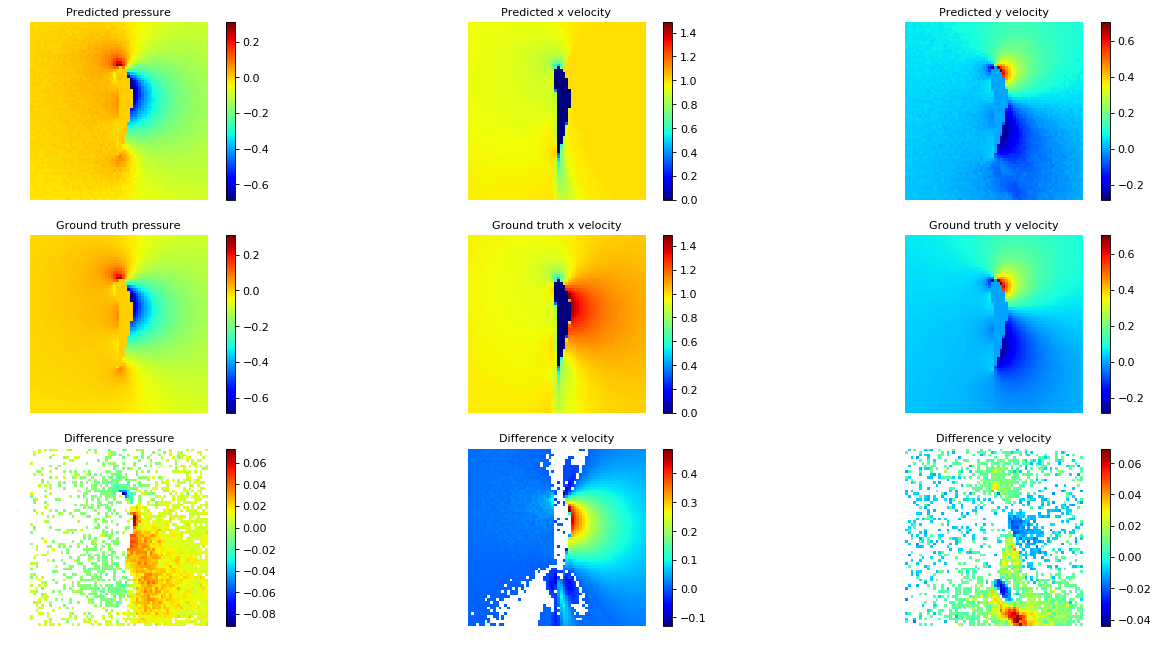

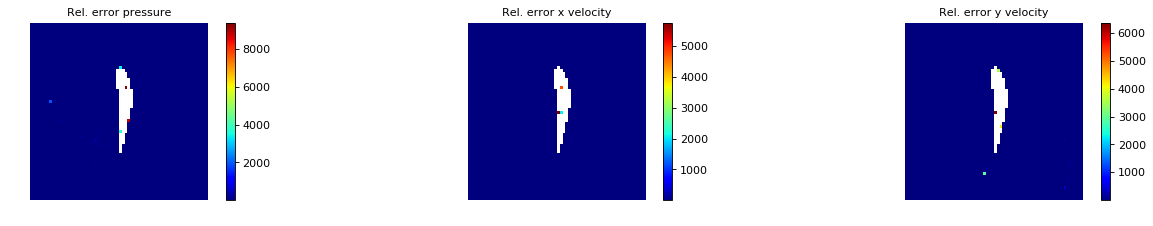

In [75]:
plotter(predictions,truth,index = args[0])

In [54]:
def get_mean_img(reference,output):
    mean_ref = reference.sum(axis = 0)/len(reference)
    mean_output = output.sum(axis = 0)/len(output)
    rel_err = []
    [rel_err.append(relative_error(mean_ref[:,:,ch], mean_output[:,:,ch])) for ch in range(0,3)]
    ref_mean_truth = np.mean(np.abs(mean_ref))
    ref_mean_pred = np.mean(np.abs(mean_output))
    return mean_ref, mean_output, rel_err, ref_mean_truth, ref_mean_pred

In [55]:
pred, target = denormalize_data(predictions, truth, n_vxmax,n_vymax)

In [56]:
mean_ref, mean_output, rel_err, ref_mean_truth, ref_mean_pred = get_mean_img(truth,predictions)

In [57]:
ref_mean_pred

0.38240373

In [58]:
ref_mean_truth

0.3961823687460507

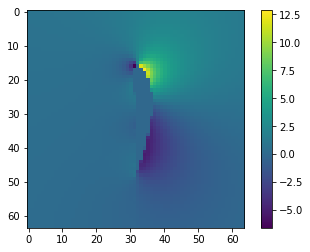

In [63]:
plt.imshow(target[0,:,:,2])
plt.colorbar()